In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/DiplomadoEPM_2019/master/Modulo3/init.py
from init import init; init(force_download=False)

replicating local resources


In [2]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
tf.__version__

setting tensorflow version in colab
TensorFlow 2.x selected.


'2.1.0'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import tensorflow as tf
from PIL import Image
from io import BytesIO
from six.moves import urllib
from tensorflow.keras.applications import inception_v3, InceptionV3
from tensorflow.keras.applications.inception_v3 import decode_predictions
from skimage.transform import resize, rescale

tf.__version__

'2.1.0'

# Lab: occlusion for interpretability

In this lab you will need to:

1. Load an image
2. Load InceptionV3
3. Obtain InceptionV3 prediction
4. Run a 100x100 occlusion window across the image with an overlapping stride of 10 pixels
5. For each position of the occlusion window record the model probability the prediction obtained in step 3
6. Create a heatmap with the recorded probabilities and scale it to the size of the original image
7. Plot the heatmap alongside the original image. You may also plot the heatmap over the image with some alpha


Use the following two images

(-0.5, 199.5, 149.5, -0.5)

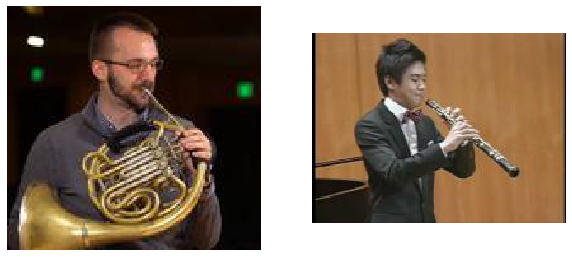

In [4]:
im1 = plt.imread("local/imgs/french-horn.jpg")
im2 = plt.imread("local/imgs/oboe.jpg")
plt.figure(figsize=(10,6))
plt.subplot(121); plt.imshow(im1); plt.axis("off")
plt.subplot(122); plt.imshow(im2); plt.axis("off")

For the french horn the resulting heatmap, before rescaling should have a size of 19x21 and the oboe 21x31.

The InceptionV3 with imagenet prediction class code fore the french horn should be 566 and for the oboe 683

The following are possible results

![](https://github.com/jdariasl/DiplomadoEPM_2019/blob/master/Modulo3/Images/lab_french-horn-occlusion.png?raw=1)

![](https://github.com/jdariasl/DiplomadoEPM_2019/blob/master/Modulo3/Images/lab_oboe-occlusion.png?raw=1)

In [25]:
aimg = plt.imread("local/imgs/french-horn.jpg")
aimg = plt.imread("local/imgs/oboe.jpg")
aimg = resize(aimg, output_shape=(299,299,3))
print (np.min(aimg), np.max(aimg), aimg.shape)

0.0 0.9989568809929087 (299, 299, 3)


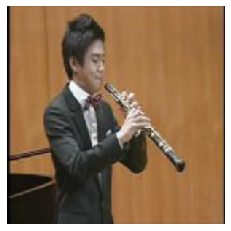

In [26]:
plt.imshow(aimg)
plt.axis("off");

In [0]:
model = InceptionV3(weights='imagenet', include_top=True)

In [28]:
pred = model.predict(aimg.reshape(-1,*aimg.shape))

class_code = np.argmax(pred[0])
print ("class_code", class_code)
print ("proability", pred[0][class_code])
print ('predicted:')
for i in decode_predictions(pred, top=5)[0]:
    print("%10s %20s %.6f"%i)


class_code 683
proability 0.82258075
predicted:
 n03838899                 oboe 0.822581
 n03372029                flute 0.140739
 n03110669               cornet 0.004988
 n02804610              bassoon 0.002184
 n04487394             trombone 0.000806


In [29]:
import math
from progressbar import progressbar as pbar

occluding_size = 100
occluding_stride = 10
occluding_pixel = np.max(aimg)
height, width, _ = aimg.shape
output_height = int(math.ceil((height-occluding_size) / occluding_stride + 1))
output_width = int(math.ceil((width-occluding_size) / occluding_stride + 1))
heatmap = np.zeros((output_height, output_width))
print (occluding_stride, output_height*output_width)


pimgs = np.zeros([output_height*output_width]+list(aimg.shape))
print (occluding_stride, pimgs.shape)
c = 0
for h in pbar(range(output_height)):
    for w in range(output_width):
        # Occluder region:
        h_start = h * occluding_stride
        w_start = w * occluding_stride
        h_end = min(height, h_start + occluding_size)
        w_end = min(width, w_start + occluding_size)
        # Getting the image copy, applying the occluding window and classifying it again:
        oimg = aimg.copy()
        oimg[h_start:h_end, w_start:w_end,:] =  occluding_pixel            
        pimg = inception_v3.preprocess_input(np.expand_dims(oimg.astype(float), axis=0))
        
        pimgs[c]=pimg[0]
        c+=1
        
        
pimgs.shape

10 441


 19% (4 of 21) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

10 (441, 299, 299, 3)


100% (21 of 21) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


(441, 299, 299, 3)

In [30]:
preds = model.predict(pimgs)
preds.shape

(441, 1000)

In [0]:
c = 0
for h in range(output_height):
    for w in range(output_width):
        heatmap[h,w] = 1-preds[c][class_code]
        c += 1

In [14]:
sheatmap = resize(heatmap, aimg.shape[:-1])
print (heatmap.shape, sheatmap.shape)

(21, 21) (299, 299)


(-0.5, 298.5, 298.5, -0.5)

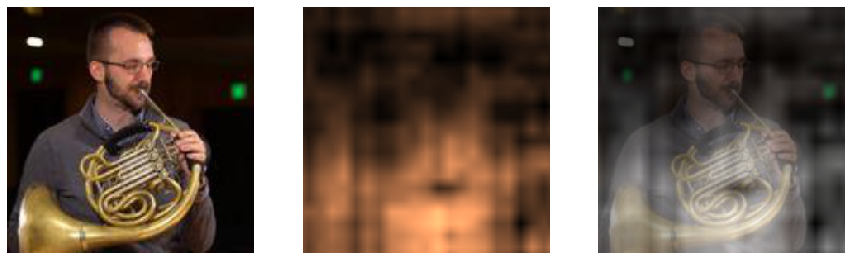

In [24]:
plt.figure(figsize=(15,6))
plt.subplot(131)
plt.imshow(aimg)
plt.axis("off")
plt.subplot(132)
plt.imshow(sheatmap, cmap=plt.cm.copper_r)
plt.axis("off")
plt.subplot(133)
plt.imshow(aimg)
plt.imshow(sheatmap, cmap=plt.cm.Greys,alpha=.7)
plt.axis("off")
